## Deep Learning
### Assignment 1

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import random
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


### Problem 1

Let's take a peek at some of the data to make sure it looks sensible. Each example should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

In [4]:
imageFolder = os.listdir('./notMNIST_large') # List of folders in the dir
for i in range(len(imageFolder)):
   fileName = os.path.join("./notMNIST_large/",random.choice(imageFolder[i])) # select an image folder at random
   imageName = os.path.join(fileName,random.choice(os.listdir(fileName)))     # select an image at random
   image = Image(imageName)
   display(image)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './notMNIST_large/l'

In [ ]:
imageFolder = os.listdir('./notMNIST_small')                                  # List of folders in the dir
for i in range(len(imageFolder)):
   fileName = os.path.join("./notMNIST_small/",random.choice(imageFolder[i])) # select an image folder at random
   imageName = os.path.join(fileName,random.choice(os.listdir(fileName)))     # select an image at random
   image = Image(imageName)
   display(image)

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.


In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

### Problem 2

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

0


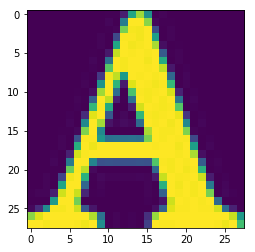

1


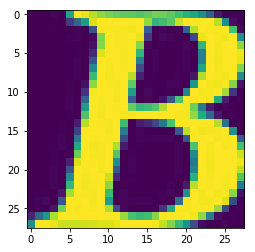

2


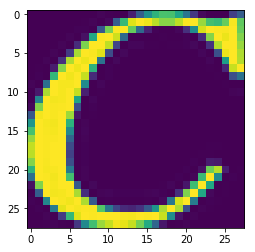

3


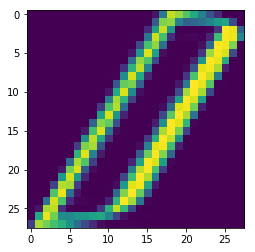

4


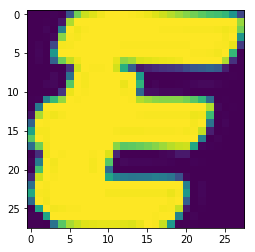

5


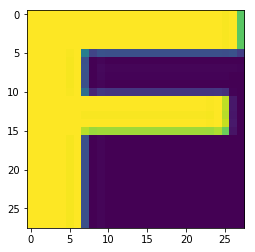

6


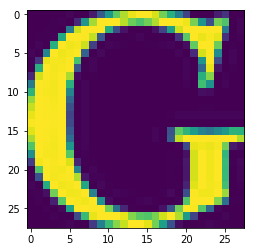

7


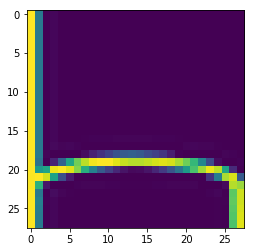

8


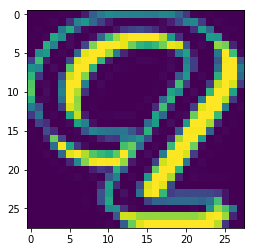

9


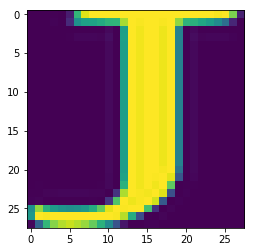

In [6]:
for label, pickle_file in enumerate(train_datasets):
    print (label)
    f = pickle.load(open(pickle_file, 'rb'))
    plt.imshow(f[random.choice(range(f.shape[0]))])
    plt.show()

### Problem 3

Another check: we expect the data to be balanced across classes. Verify that.

In [7]:
training_labels = np.zeros(10)
for label, pickle_file in enumerate(train_datasets):
    training_labels[label] = (pickle.load(open(pickle_file, 'rb')).shape[0])
testing_labels = np.zeros(10)
for label, pickle_file in enumerate(test_datasets):
    testing_labels[label] = (pickle.load(open(pickle_file, 'rb')).shape[0])
print ("Train: ", training_labels, ", std: ", np.std(training_labels))
print ("Test: ", testing_labels, ", std: ", np.std(testing_labels))


Train:  [ 52909.  52911.  52912.  52911.  52912.  52912.  52912.  52912.  52912.
  52911.] , std:  0.916515138991
Test:  [ 1872.  1873.  1873.  1873.  1873.  1872.  1872.  1872.  1872.  1872.] , std:  0.489897948557


Answer: 
Train:  [ 52909.  52911.  52912.  52911.  52912.  52912.  52912.  52912.  52912.
  52911.] , std:  0.916515138991
Test:  [ 1872.  1873.  1873.  1873.  1873.  1872.  1872.  1872.  1872.  1872.] , std:  0.489897948557    

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.


In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

### Problem 4

Convince yourself that the data is still good after shuffling!

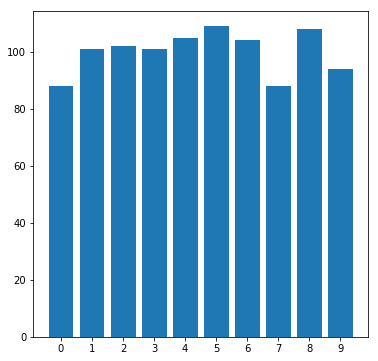

In [10]:
samples = 1000
plt.figure(figsize=(6,6))
plt.bar(range(10), np.bincount(train_labels[:samples])) # bincount used for frequency count
plt.xticks(range(10));

Finally, let's save the data for later reuse:

In [ ]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 5870755


### Problem 5

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:

    What about near duplicates between datasets? (images that are almost identical)
    Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.



In [74]:
import time
import hashlib

t1 = time.time()

train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

valid_in_train = np.in1d(valid_hashes, train_hashes)
test_in_train  = np.in1d(test_hashes,  train_hashes)
test_in_valid  = np.in1d(test_hashes,  valid_hashes)

valid_keep = ~valid_in_train
test_keep  = ~(test_in_train | test_in_valid)

valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean  = valid_labels [valid_keep]

test_dataset_clean = test_dataset[test_keep]
test_labels_clean  = test_labels [test_keep]

t2 = time.time()

print("Time: %0.2fs" % (t2 - t1))
print("valid -> train overlap: %d samples" % valid_in_train.sum())
print("test  -> train overlap: %d samples" % test_in_train.sum())
print("test  -> valid overlap: %d samples" % test_in_valid.sum())

Time: 2.24s
valid -> train overlap: 1067 samples
test  -> train overlap: 1324 samples
test  -> valid overlap: 200 samples


### Problem 6

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

In [49]:
# Logistic Regression Model
lr_model = LogisticRegression(penalty='l2',         # penalization norm
                             dual=False,                 # Dual or primal formulation. implemented for l2 if liblinear solver.if 
                             tol=0.0001,                 # Tolerance for stopping criteria
                             C=1.0,                      # Inverse of regularization strength; smaller values specify stronger regularization
                             fit_intercept=True,         # Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
                             intercept_scaling=1,        # Useful only when the solver ‘liblinear’ is used and self.fit_intercept is set to True.
                             class_weight=None,          
                             random_state=None, 
                             solver='sag',               # Stochastic Average Gradient
                             max_iter=10000, 
                             multi_class='multinomial', 
                             verbose=1, 
                             n_jobs=1)

In [55]:
import sklearn
np.random.seed(100)
# For 50 samples
index = random.sample(range(len(train_dataset)), 50)
xtrain_50 = train_dataset.reshape(len(train_dataset), -1)[index]
ytrain_50 = train_labels[index]
lr_model.fit(xtrain_50, ytrain_50)

## predict
ypred_train = lr_model.predict(xtrain_50)
ypred_val = lr_model.predict(valid_dataset.reshape(len(valid_dataset), -1))
ypred_test = lr_model.predict(test_dataset.reshape(len(test_dataset), -1))

## check accuracy
print ("Accuracy Score on Training Set: ",sklearn.metrics.accuracy_score(ytrain_50, ypred_train) )
print ("Accuracy Score on Validation Set: ",sklearn.metrics.accuracy_score(valid_labels, ypred_val) )
print ("Accuracy Score on Test Set: ",sklearn.metrics.accuracy_score(test_labels, ypred_test) )

convergence after 1012 epochs took 3 seconds
Accuracy Score on Training Set:  1.0
Accuracy Score on Validation Set:  0.5426
Accuracy Score on Test Set:  0.5853


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


- Accuracy Score on Training Set:  1.0
- Accuracy Score on Validation Set:  0.5462
- Accuracy Score on Test Set:  0.5853

In [56]:
# For 100 samples
index = random.sample(range(len(train_dataset)), 100)
xtrain_100 = train_dataset.reshape(len(train_dataset), -1)[index]
ytrain_100 = train_labels[index]

lr_model.fit(xtrain_100, ytrain_100)

## predict
ypred_train = lr_model.predict(xtrain_100)
ypred_val = lr_model.predict(valid_dataset.reshape(len(valid_dataset), -1))
ypred_test = lr_model.predict(test_dataset.reshape(len(test_dataset), -1))

## check accuracy
print ("Accuracy Score on Training Set: ",sklearn.metrics.accuracy_score(ytrain_100, ypred_train) )
print ("Accuracy Score on Validation Set: ",sklearn.metrics.accuracy_score(valid_labels, ypred_val) )
print ("Accuracy Score on Test Set: ",sklearn.metrics.accuracy_score(test_labels, ypred_test) ) 

convergence after 725 epochs took 7 seconds
Accuracy Score on Training Set:  1.0
Accuracy Score on Validation Set:  0.6317
Accuracy Score on Test Set:  0.6919


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished


- Accuracy Score on Training Set: 1.0
- Accuracy Score on Validation Set:  0.6317
- Accuracy Score on Test Set:  0.6919

In [57]:
# For 1000 samples
index = random.sample(range(len(train_dataset)), 1000)
xtrain_1000 = train_dataset.reshape(len(train_dataset), -1)[index]
ytrain_1000 = train_labels[index]

lr_model.fit(xtrain_1000, ytrain_1000)

## predict
ypred_train = lr_model.predict(xtrain_1000)
ypred_val = lr_model.predict(valid_dataset.reshape(len(valid_dataset), -1))
ypred_test = lr_model.predict(test_dataset.reshape(len(test_dataset), -1))

## check accuracy
print ("Accuracy Score on Training Set: ",sklearn.metrics.accuracy_score(ytrain_1000, ypred_train) )
print ("Accuracy Score on Validation Set: ",sklearn.metrics.accuracy_score(valid_labels, ypred_val) )
print ("Accuracy Score on Test Set: ",sklearn.metrics.accuracy_score(test_labels, ypred_test) )

convergence after 507 epochs took 41 seconds
Accuracy Score on Training Set:  1.0
Accuracy Score on Validation Set:  0.7599
Accuracy Score on Test Set:  0.8322


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.3s finished


- Accuracy Score on Training Set:  1.0
- Accuracy Score on Validation Set:  0.7599
- Accuracy Score on Test Set:  0.8322

In [58]:
# For 5000 samples
index = random.sample(range(len(train_dataset)), 5000)
xtrain_5000 = train_dataset.reshape(len(train_dataset), -1)[index]
ytrain_5000 = train_labels[index]

lr_model.fit(xtrain_5000, ytrain_5000)

## predict
ypred_train = lr_model.predict(xtrain_5000)
ypred_val = lr_model.predict(valid_dataset.reshape(len(valid_dataset), -1))
ypred_test = lr_model.predict(test_dataset.reshape(len(test_dataset), -1))

## check accuracy
print ("Accuracy Score on Training Set: ",sklearn.metrics.accuracy_score(ytrain_5000, ypred_train) )
print ("Accuracy Score on Validation Set: ",sklearn.metrics.accuracy_score(valid_labels, ypred_val) )
print ("Accuracy Score on Test Set: ",sklearn.metrics.accuracy_score(test_labels, ypred_test) )

convergence after 166 epochs took 65 seconds
Accuracy Score on Training Set:  0.9684
Accuracy Score on Validation Set:  0.7615
Accuracy Score on Test Set:  0.8375


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


- Accuracy Score on Training Set:  0.9684
- Accuracy Score on Validation Set:  0.7615
- Accuracy Score on Test Set:  0.8375

In [59]:
# For 10000 samples
index = random.sample(range(len(train_dataset)), 10000)
xtrain_10000 = train_dataset.reshape(len(train_dataset), -1)[index]
ytrain_10000 = train_labels[index]

lr_model.fit(xtrain_10000, ytrain_10000)

## predict
ypred_train = lr_model.predict(xtrain_10000)
ypred_val = lr_model.predict(valid_dataset.reshape(len(valid_dataset), -1))
ypred_test = lr_model.predict(test_dataset.reshape(len(test_dataset), -1))

## check accuracy
print ("Accuracy Score on Training Set: ",sklearn.metrics.accuracy_score(ytrain_10000, ypred_train) )
print ("Accuracy Score on Validation Set: ",sklearn.metrics.accuracy_score(valid_labels, ypred_val) )
print ("Accuracy Score on Test Set: ",sklearn.metrics.accuracy_score(test_labels, ypred_test) )

convergence after 193 epochs took 149 seconds
Accuracy Score on Training Set:  0.925
Accuracy Score on Validation Set:  0.7809
Accuracy Score on Test Set:  0.8613


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


- Accuracy Score on Training Set: 0.925
- Accuracy Score on Validation Set:  0.7809
- Accuracy Score on Test Set:  0.8613

In [69]:
# Another method from the forum
## Reshaping done differently 
train_dataset_lin = train_dataset.reshape(train_dataset.shape[0],train_dataset.shape[1]*train_dataset.shape[2])
test_dataset_lin = test_dataset.reshape(test_dataset.shape[0],test_dataset.shape[1]*test_dataset.shape[2])
valid_dataset_lin = valid_dataset.reshape(valid_dataset.shape[0],valid_dataset.shape[1]*valid_dataset.shape[2])

#train_dataset_lin = train_dataset.reshape(len(train_dataset), -1)
#test_dataset_lin = test_dataset.reshape(len(test_dataset), -1)
#valid_dataset_lin = valid_dataset.reshape(len(valid_dataset), -1)

score_train=[]
score_test=[]
score_valid=[]
numel_vector = [50, 100, 250, 500, 1000, 2500, 5000, 10000]
for numel in numel_vector:   
    idx = random.sample(range(len(train_labels)),numel)
    lr_model.fit(train_dataset_lin[idx,:], train_labels[idx])
              
    res = lr_model.predict(train_dataset_lin[idx,:])
    score_train.append( sklearn.metrics.accuracy_score(train_labels[idx], res) )

    res = lr_model.predict(test_dataset_lin)
    score_test.append( sklearn.metrics.accuracy_score(test_labels, res) )

    res = lr_model.predict(valid_dataset_lin)
    score_valid.append( sklearn.metrics.accuracy_score(valid_labels, res) )
    
print(score_train)
print(score_test)
print(score_valid)

convergence after 446 epochs took 2 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


convergence after 928 epochs took 5 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


convergence after 410 epochs took 6 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


convergence after 503 epochs took 14 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s finished


convergence after 311 epochs took 18 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s finished


convergence after 151 epochs took 22 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.3s finished


convergence after 187 epochs took 53 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.0s finished


convergence after 194 epochs took 114 seconds
[1.0, 1.0, 1.0, 1.0, 0.999, 0.99319999999999997, 0.97260000000000002, 0.92479999999999996]
[0.67569999999999997, 0.75780000000000003, 0.81520000000000004, 0.82189999999999996, 0.84619999999999995, 0.83860000000000001, 0.84960000000000002, 0.85550000000000004]
[0.61399999999999999, 0.69289999999999996, 0.73460000000000003, 0.75349999999999995, 0.76970000000000005, 0.76280000000000003, 0.77790000000000004, 0.78190000000000004]


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


- accuracy on training data:[1.0, 1.0, 1.0, 1.0, 0.999, 0.99319999999999997, 0.97260000000000002, 0.92479999999999996]
- accuracy on test data: [0.67569999999999997, 0.75780000000000003, 0.81520000000000004, 0.82189999999999996, 0.84619999999999995, 0.83860000000000001, 0.84960000000000002, 0.85550000000000004]
- accuracy on validation data: [0.61399999999999999, 0.69289999999999996, 0.73460000000000003, 0.75349999999999995, 0.76970000000000005, 0.76280000000000003, 0.77790000000000004, 0.78190000000000004]

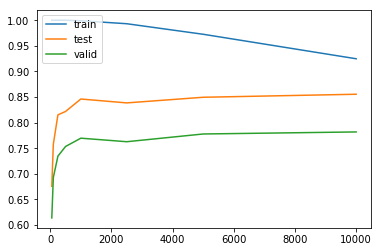

In [70]:
plt.plot(numel_vector, score_train, numel_vector, score_test, numel_vector, score_valid)
plt.legend(['train', 'test', 'valid'], loc='upper left')
plt.show()

In [71]:
# Train the model on full training set
lr_model.fit(train_dataset.reshape(len(train_dataset), -1), train_labels)

## predict
ypred_train = lr_model.predict(train_dataset.reshape(len(train_dataset), -1))
ypred_val = lr_model.predict(valid_dataset.reshape(len(valid_dataset), -1))
ypred_test = lr_model.predict(test_dataset.reshape(len(test_dataset), -1))

## check accuracy
print ("Accuracy Score on Training Set: ",sklearn.metrics.accuracy_score(train_labels, ypred_train) )
print ("Accuracy Score on Validation Set: ",sklearn.metrics.accuracy_score(valid_labels, ypred_val) )
print ("Accuracy Score on Test Set: ",sklearn.metrics.accuracy_score(test_labels, ypred_test) )

convergence after 62 epochs took 719 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.0min finished


Accuracy Score on Training Set:  0.840235
Accuracy Score on Validation Set:  0.8313
Accuracy Score on Test Set:  0.9006


- Accuracy Score on Training Set: 0.840235
- Accuracy Score on Validation Set:  0.8313
- Accuracy Score on Test Set:  0.9006

Repeat the whole process for cleaned data set- no duplicates